<a href="https://colab.research.google.com/github/yusufboran/r_case_studies/blob/main/colab/btc_Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

## Library

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

                                   Open
Date                                   
2022-10-30 00:00:00+00:00  20817.982422
2022-10-31 00:00:00+00:00  20633.695312
2022-11-01 00:00:00+00:00  20494.898438
2022-11-02 00:00:00+00:00  20482.958984
2022-11-03 00:00:00+00:00  20162.689453
...                                 ...
2024-10-26 00:00:00+00:00  66628.734375
2024-10-27 00:00:00+00:00  67023.476562
2024-10-28 00:00:00+00:00  67922.671875
2024-10-29 00:00:00+00:00  69910.046875
2024-10-30 00:00:00+00:00  72707.632812

[732 rows x 1 columns]


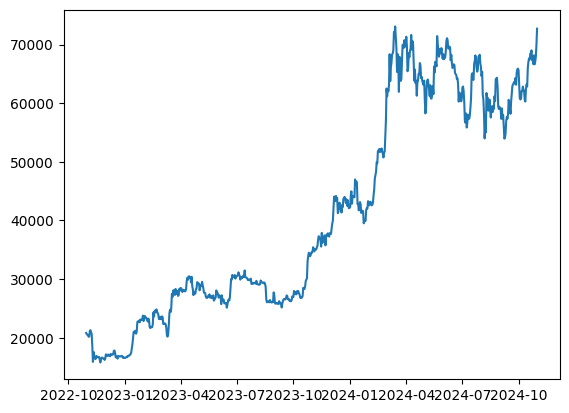

In [49]:
import yfinance as yf

 #Örnek olarak Apple (AAPL) hisse senedi için
#aapl = yf.Ticker("AAPL")
#aapl_data = aapl.history(period="1d")
#print(aapl_data)
# Bitcoin için
btc = yf.Ticker("BTC-USD")

# Son 60 günün saatlik verilerini al
btc_data = btc.history(period="2y", interval="1d")  # Son 60 gün, her saatlik veri

btc_open_data = btc_data[['Open']]
print(btc_open_data)

plt.plot(btc_open_data, label = 'BTC Data')
plt.show()

## Dataloading

In [50]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(btc_open_data)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [51]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

In [52]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05574
Epoch: 100, loss: 0.00052
Epoch: 200, loss: 0.00042
Epoch: 300, loss: 0.00036
Epoch: 400, loss: 0.00029
Epoch: 500, loss: 0.00024
Epoch: 600, loss: 0.00021
Epoch: 700, loss: 0.00020
Epoch: 800, loss: 0.00019
Epoch: 900, loss: 0.00019
Epoch: 1000, loss: 0.00019
Epoch: 1100, loss: 0.00019
Epoch: 1200, loss: 0.00018
Epoch: 1300, loss: 0.00018
Epoch: 1400, loss: 0.00018
Epoch: 1500, loss: 0.00018
Epoch: 1600, loss: 0.00018
Epoch: 1700, loss: 0.00018
Epoch: 1800, loss: 0.00018
Epoch: 1900, loss: 0.00018


## Testing for Airplane Passengers Dataset

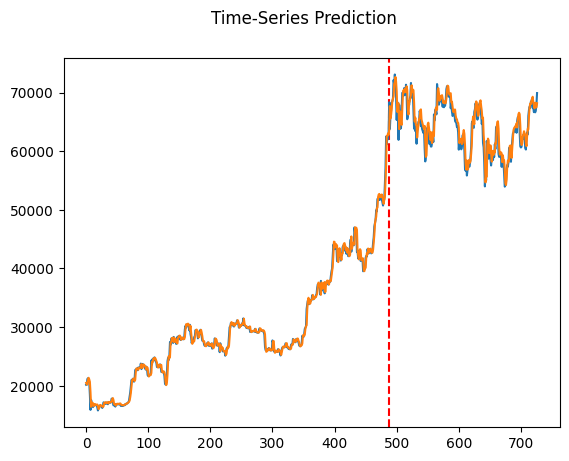

In [53]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

tahminler = dataY_plot
gercek_veri = data_predict


# Renkli yazdırma fonksiyonu
def renkli_yazdir(mesaj, pozitif=True):
    if pozitif:
        print(f"\033[92m{mesaj}\033[0m")  # Yeşil
    else:
        print(f"\033[91m{mesaj}\033[0m")  # Kırmızı

# 1. Ortalama Mutlak Hata (MAE)
mae = mean_absolute_error(gercek_veri, tahminler)
renkli_yazdir(f"MAE (Ortalama Mutlak Hata): {mae}", pozitif=mae < 10)

# 2. Ortalama Kare Hata (MSE)
mse = mean_squared_error(gercek_veri, tahminler)
renkli_yazdir(f"MSE (Ortalama Kare Hata): {mse}", pozitif=mse < 100)

# 3. Kök Ortalama Kare Hata (RMSE)
rmse = np.sqrt(mse)
renkli_yazdir(f"RMSE (Kök Ortalama Kare Hata): {rmse}", pozitif=rmse < 10)

# 4. Ortalama Mutlak Yüzde Hata (MAPE)
mape = np.mean(np.abs((gercek_veri - tahminler) / gercek_veri)) * 100
renkli_yazdir(f"MAPE (Ortalama Mutlak Yüzde Hata): {mape}%", pozitif=mape < 10)

# 5. Determinasyon Katsayısı (R^2)
r2 = r2_score(gercek_veri, tahminler)
renkli_yazdir(f"R^2 (Determinasyon Katsayısı): {r2}", pozitif=r2 >= 0.7)

MAE (Ortalama Mutlak Hata): 779.4463500976562
MSE (Ortalama Kare Hata): 1477597.875
RMSE (Kök Ortalama Kare Hata): 1215.5648193359375
MAPE (Ortalama Mutlak Yüzde Hata): 1.8044529482722282%
R^2 (Determinasyon Katsayısı): 0.995561420917511
